# Load FIRE Data


In [45]:
# Import the main analysis module
import gizmo_analysis as gizmo

In [46]:
# Choose the simulation directory
simulation_directory = '/home/jovyan/fire2/m12i'

In [47]:
# read star particles and gas cells at z = 0
part = gizmo.io.Read.read_snapshots(['star', 'dark'], 'redshift', 0, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/fire2/m12i/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/fire2/m12i/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'dark']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  home/jovyan/fire2/m12i/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties


# in gizm

# Extract parameters from FIRE

In [48]:
# Display keys
print( part.keys() )
print( part['star'].keys() )
print( part['dark'].keys() )

dict_keys(['star', 'dark'])
dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'potential', 'form.scalefactor', 'velocity'])
dict_keys(['position', 'mass', 'id.child', 'id.generation', 'id', 'potential', 'velocity'])


In [150]:
# Declare parameters for star and dark matter particles
starPos = part['star'].prop('host.distance') # star position in kpc
starMass = part['star']['mass']              # star mass in solar masses
starVel = part['star'].prop('host.velocity') # star velocity in km/s

darkPos = part['dark'].prop('host.distance') # dark position in kpc
darkMass = part['dark']['mass']              # dark mass in solar masses
darkVel = part['dark'].prop('host.velocity') # dark velocity in km/s

# Graph density plots and find coefs

In [159]:
# Import modules for graphing 
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Import modules for curve fitting
import scipy
from scipy.optimize import curve_fit

Note: in both graphing codes below:
* edges = bin edges of the histogram computed for the radial data
* edges[1:] = all the bin edges except for the lower edge of the first bin
* edges[:-1] = all bin edges except for the upper edge of the last bin

In [143]:
# Define the bin edges
rmin = 0  # minimum radius
rmax = 20  # maximum radius
bins = 200  # number of bins

In [142]:
# Curve fitting quations:
# density = r ^ -(alpha + 2)
# density = r ^ -gamma
# beta = 1 - (sigma_t^2 / sigma_r^2) where sigma_t is tangential velocity dispersion

### Star density profile

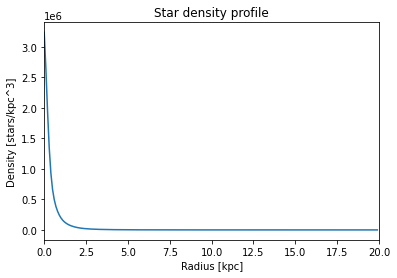

In [206]:
# Compute radial distance
radialStar = np.sqrt((starPos[:,0])**2 + (starPos[:,1])**2 + (starPos[:,2])**2)

# Compute the density profile
counts, edges = np.histogram(radialStar, bins=bins, range=(rmin, rmax))
volume = 4.0/3.0 * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
density = counts / volume

# Plot the density profile
fig, ax = plt.subplots()
ax.plot(edges[:-1], density)
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Density [stars/kpc^3]')
ax.set_xlim(rmin, rmax)
plt.title('Star density profile')
plt.show()

### Calculate gamma from the star population

In [207]:
# Objective function
def objective(r, gamma):
 return np.power(r,-gamma)

# Call curve_fit 
popt, pcov = curve_fit(objective, edges[1:], density)

# Assign gamma from the stellar data fit
gamma = popt[0]
print("Gamma = ", gamma)

Gamma =  6.513147120273701


### Calculate beta from the star population

In [208]:
# Import modules to calculate beta
import beta

# Call beta function to calculate anisotropy from 3d pos and vel arrays
beta = beta.beta(starPos, starVel)
print("Beta = ", beta)

Beta =  0.12881259099244435


### Dark matter density profile

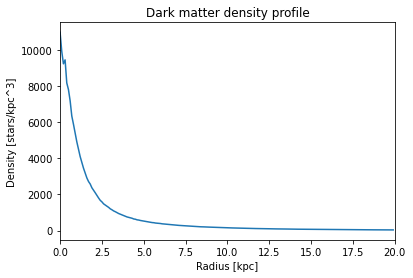

In [209]:
# Compute radial distance
radialDark = np.sqrt((darkPos[:,0])**2 + (darkPos[:,1])**2 + (darkPos[:,2])**2)

# Compute the density profile
counts, edges = np.histogram(radialDark, bins=bins, range=(rmin, rmax))
volume = 4.0/3.0 * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
density = counts / volume

# Plot the density profile
fig, ax = plt.subplots()
ax.plot(edges[:-1], density)
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Density [stars/kpc^3]')
ax.set_xlim(rmin, rmax)
plt.title('Dark matter density profile')
plt.show()

### Calculate alpha from dark matter population

In [210]:
# Objective function
def objective(r, gammaDark):
 return np.power(r,-gammaDark)

# Call curve_fit 
popt, pcov = curve_fit(objective, edges[1:], density)

# Assign gamma
gammaDark = popt[0]

# Calculate alpha 
alpha = gammaDark - 2
print("Alpha = ", alpha)

Alpha =  2.0585414176233794


# Use mass estimator

In [211]:
# Import
import mass_estimators

In [212]:
# Call the profile estimator 
# mass_estimator_profile(alpha, beta, gamma, pos, vel, r_in, r_out, nbins=30)
mass = mass_estimators.mass_estimator_profile(alpha, beta, gamma, starPos, starVel, rmin, rmax, nbins=30)

Returns:
  
	--------
	r : numpy.ndarray
		galactocentric distance bins
	mass_v : numpy.ndarray
		enclosed mass profile computed with 3d velocities
	mass_vr : numpy.ndarray
		enclosed mass profile computed with radial velocities	

In [213]:
# Testing shapes
print(mass[0].shape)
print(mass[1].shape)
print(mass[2].shape)

(29,)
(30,)
(30,)


In [214]:
# Assign radius and mass outputs. 
radius = mass[0]
mass_v = mass[1]
mass_vr = mass[2]

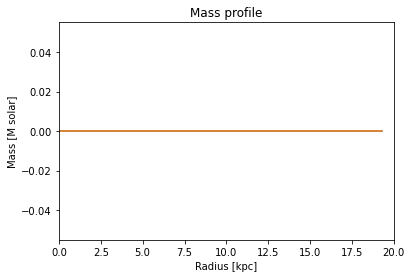

In [215]:
# Plot the mass profile
fig, ax = plt.subplots()
ax.plot(radius, mass_v[1:], label='mass_v')
ax.plot(radius, mass_vr[1:], label='mass_vr')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [M solar]')
ax.set_xlim(rmin, rmax)
plt.title('Mass profile')
plt.show()